In [99]:
# Import the necessary packages
import pandas as pd
from pandas import read_csv
from matplotlib import pyplot
from pandas.plotting import lag_plot
from pandas import DataFrame
from pandas import concat
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.ar_model import AutoReg
from math import sqrt
import numpy as np
import seaborn as sns
import os
import matplotlib.pyplot as plt
from matplotlib.dates import DayLocator, HourLocator, DateFormatter, drange
import matplotlib.dates as mdates
import windrose
from windrose import WindroseAxes, plot_windrose

In [66]:
# Change the directory
os.chdir('/Users/f67f911/Desktop/Hourglass_WX/Data/Cleaned')

In [70]:
# Now upload the Hourly data
hourly_df = read_csv('hg_hourly_cleaned.csv', header=0, index_col=0)
hourly_df.head()

,Timestamp,AirTemp_DegC,Avg_AirTemp_DegC,RH%,SnowDepth_m,Q,WindSpeed_Max_m/s,WindSpeed_m/s,WindDir_D1_Deg,WindDir_SD1_Deg,...,CNR4TC_C,CNR4TK_K,RsNet_W/m^2,RlNet_W/m^2,Albedo%,Rn_W/m^2,LUpCo_W/m^2,LDnCo_W/m^2,Shortwave_Albedo_W/m^2,Longwave_Albedo_W/m^2
1,2021-01-14 15:00:00,-9.99,-9.95,57.89,0.957,176,1.019,0.292,251.6,68.82,...,-10.89,262.3,2.254,-46.21,0.89,-43.96,202.6,248.8,0.890297,0.295579
2,2021-01-14 16:00:00,-11.38,-10.75,64.55,0.959,178,1.568,0.298,222.7,50.27,...,-12.63,260.5,0.451,-40.13,0.97,-39.68,201.9,242,0.969557,0.323157
3,2021-01-14 17:00:00,-11.74,-11.24,64.83,0.958,172,1.999,0.408,241.9,45.79,...,-12.88,260.3,-2.255,-39.91,3.5,-42.17,200.9,240.8,NaN,0.326981
4,2021-01-14 18:00:00,-11.23,-11.68,61.18,0.953,172,2.470,0.559,283.5,31.98,...,-13.04,260.1,-2.481,-39.24,-1.75,-41.72,201.4,240.6,NaN,0.325541
5,2021-01-14 19:00:00,-10.48,-11.26,57.20,0.951,180,2.156,0.594,269.2,53.66,...,-12.51,260.6,-2.932,-38.56,-2.25,-41.49,203.5,242,NaN,0.337229


In [71]:
# First, we need to filter to ONLY include our field season
season_start = '2021-10-01'
season_end = '2022-06-31'

In [72]:
# Now create a mask and filter the hourly data by this same period
mask_season = (hourly_df['Timestamp'] >= season_start) & (hourly_df['Timestamp'] <= season_end)
hourly_df = hourly_df.loc[mask_season]
hourly_df.head()

,Timestamp,AirTemp_DegC,Avg_AirTemp_DegC,RH%,SnowDepth_m,Q,WindSpeed_Max_m/s,WindSpeed_m/s,WindDir_D1_Deg,WindDir_SD1_Deg,...,CNR4TC_C,CNR4TK_K,RsNet_W/m^2,RlNet_W/m^2,Albedo%,Rn_W/m^2,LUpCo_W/m^2,LDnCo_W/m^2,Shortwave_Albedo_W/m^2,Longwave_Albedo_W/m^2
6226,2021-10-01 00:00:00,4.189,4.281,43.48,0.584,281,1.646,0.406,228.6,25.69,...,2.301,275.5,-0.675,-39.84,-2,-40.52,266.1,305.9,NaN,0.339466
6227,2021-10-01 01:00:00,3.522,4.103,45.47,0.579,248,0.804,0.304,222.9,13.70,...,1.865,275.0,-0.9,-38.72,-0.333,-39.62,265.1,303.9,NaN,0.345946
6228,2021-10-01 02:00:00,3.846,3.952,44.36,0.591,254,0.882,0.218,227.2,17.10,...,1.650,274.8,-1.576,-39.62,-6,-41.2,264.6,304.2,NaN,0.325617
6229,2021-10-01 03:00:00,3.451,4.064,45.01,0.585,358,1.940,0.365,250.6,30.13,...,1.736,274.9,-1.576,-41.2,-0.4,-42.77,263.6,304.8,NaN,0.314642
6230,2021-10-01 04:00:00,2.633,2.897,47.41,0.524,274,1.254,0.137,253.2,21.76,...,0.546,273.7,-1.801,-38.27,-7,-40.07,262.1,300.4,NaN,0.317217


In [73]:
# Now, convert the hourly_df to labels
hourly_df['labels'] = pd.to_datetime(hourly_df['Timestamp']).dt.strftime('%b %d')

In [74]:
# Filter the hourly data to not include erroneous data
# We know that depths greater than 2.0 meters are incorrect
hourly_df['SnowDepth_m'] = np.where((0 <= hourly_df['SnowDepth_m']) & (hourly_df['SnowDepth_m'] < 2.0), hourly_df['SnowDepth_m'], np.nan)

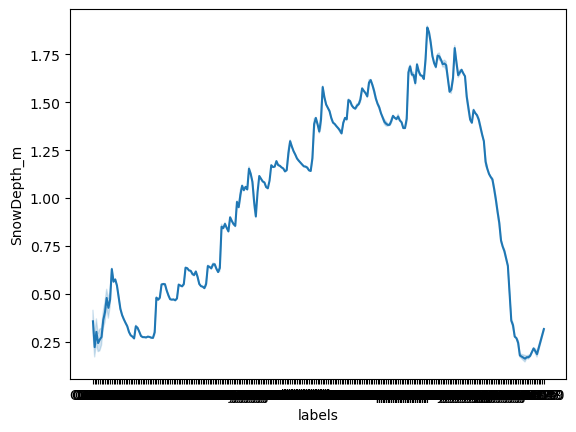

In [80]:
lineplot = sns.lineplot(data = hourly_df, x = 'labels', y = 'SnowDepth_m')

In [82]:
hourly_df.head()

,Timestamp,AirTemp_DegC,Avg_AirTemp_DegC,RH%,SnowDepth_m,Q,WindSpeed_Max_m/s,WindSpeed_m/s,WindDir_D1_Deg,WindDir_SD1_Deg,...,CNR4TK_K,RsNet_W/m^2,RlNet_W/m^2,Albedo%,Rn_W/m^2,LUpCo_W/m^2,LDnCo_W/m^2,Shortwave_Albedo_W/m^2,Longwave_Albedo_W/m^2,labels
6226,2021-10-01 00:00:00,4.189,4.281,43.48,0.584,281,1.646,0.406,228.6,25.69,...,275.5,-0.675,-39.84,-2,-40.52,266.1,305.9,NaN,0.339466,Oct 01
6227,2021-10-01 01:00:00,3.522,4.103,45.47,0.579,248,0.804,0.304,222.9,13.70,...,275.0,-0.9,-38.72,-0.333,-39.62,265.1,303.9,NaN,0.345946,Oct 01
6228,2021-10-01 02:00:00,3.846,3.952,44.36,0.591,254,0.882,0.218,227.2,17.10,...,274.8,-1.576,-39.62,-6,-41.2,264.6,304.2,NaN,0.325617,Oct 01
6229,2021-10-01 03:00:00,3.451,4.064,45.01,0.585,358,1.940,0.365,250.6,30.13,...,274.9,-1.576,-41.2,-0.4,-42.77,263.6,304.8,NaN,0.314642,Oct 01
6230,2021-10-01 04:00:00,2.633,2.897,47.41,0.524,274,1.254,0.137,253.2,21.76,...,273.7,-1.801,-38.27,-7,-40.07,262.1,300.4,NaN,0.317217,Oct 01


[Text(0.5, 1.0, 'Snow Depth Evolution for Field Season')]

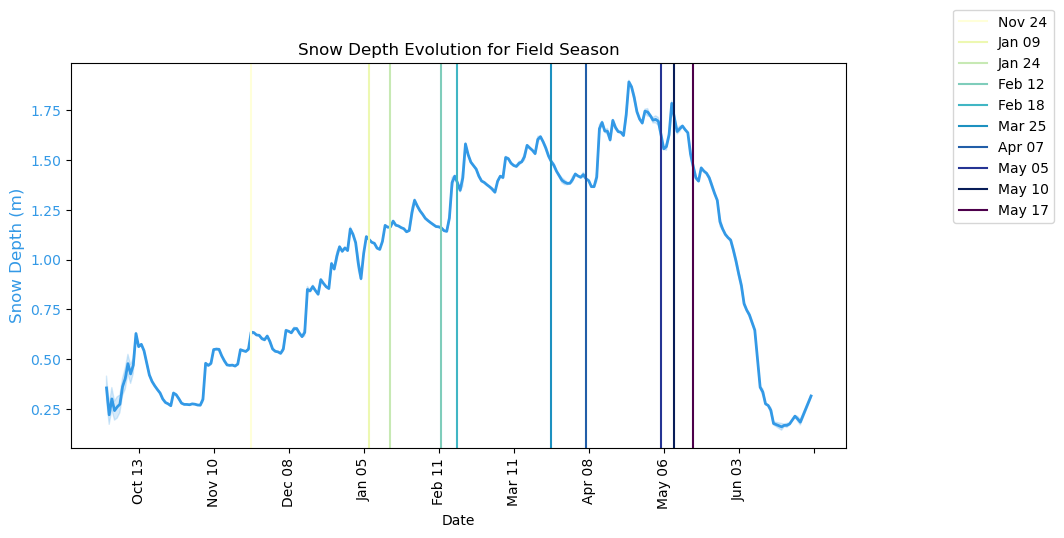

In [141]:
color_dens = "#69b3a2"
color_depth = "#3399e6"

fig, ax1 = plt.subplots(figsize=(10, 5))

sdepth = sns.lineplot(data = hourly_df, x = 'labels', y = 'SnowDepth_m', ax = ax1, color = color_depth, lw = 2)

# Ensure a major tick for each week using (interval=1) 
sdepth.xaxis.set_major_locator(mdates.WeekdayLocator(interval=4))

ax1.set_xlabel("Date")
ax1.set_ylabel("Snow Depth (m)", color=color_depth, fontsize=12)
ax1.tick_params(axis="y", labelcolor=color_depth)
plt.xticks(rotation = 90)

# ax2 = ax1.twinx()
# sns.lineplot(data = hourly_df, x = 'labels', y = 'Avg_AirTemp_DegC', ax = ax2, color = color_dens, lw = 2)

# ax2.set_ylabel("Density (kg/m^3)", color=color_dens, fontsize=12)
# ax2.tick_params(axis="y", labelcolor=color_dens)

ax1.axvline(x = 'Nov 24', label = 'Nov 24', color = '#ffffd9')
ax1.axvline(x = 'Jan 09', label = 'Jan 09', color = '#edf8b1')
ax1.axvline(x = 'Jan 24', label = 'Jan 24', color = '#c7e9b4')
ax1.axvline(x = 'Feb 12', label = 'Feb 12', color = '#7fcdbb')
ax1.axvline(x = 'Feb 18', label = 'Feb 18', color = '#41b6c4')
ax1.axvline(x = 'Mar 25', label = 'Mar 25', color = '#1d91c0')
ax1.axvline(x = 'Apr 07', label = 'Apr 07', color = '#225ea8')
ax1.axvline(x = 'May 05', label = 'May 05', color = '#253494')
ax1.axvline(x = 'May 10', label = 'May 10', color = '#081d58')
ax1.axvline(x = 'May 17', label = 'May 17', color = '#4d004b')

fig.legend(bbox_to_anchor = (1.0, 1), loc = 'upper left')
ax1.set(title = 'Snow Depth Evolution for Field Season')


In [75]:
# View the dates of the seasonal max
season_max = (hourly_df[hourly_df.SnowDepth_m == hourly_df.SnowDepth_m.max()])
season_max

,Timestamp,AirTemp_DegC,Avg_AirTemp_DegC,RH%,SnowDepth_m,Q,WindSpeed_Max_m/s,WindSpeed_m/s,WindDir_D1_Deg,WindDir_SD1_Deg,...,CNR4TK_K,RsNet_W/m^2,RlNet_W/m^2,Albedo%,Rn_W/m^2,LUpCo_W/m^2,LDnCo_W/m^2,Shortwave_Albedo_W/m^2,Longwave_Albedo_W/m^2,labels
18072,2022-04-23 11:00:00,-3.854,-3.471,92.9,1.918,171,0.0,0.0,0.0,0.0,...,270.6,NAN,NAN,NAN,NAN,NAN,NAN,NaN,NaN,Apr 23


In [76]:
max_period = hourly_df.loc[hourly_df['Timestamp'] >= '2022-04-20']
max_period.head()

,Timestamp,AirTemp_DegC,Avg_AirTemp_DegC,RH%,SnowDepth_m,Q,WindSpeed_Max_m/s,WindSpeed_m/s,WindDir_D1_Deg,WindDir_SD1_Deg,...,CNR4TK_K,RsNet_W/m^2,RlNet_W/m^2,Albedo%,Rn_W/m^2,LUpCo_W/m^2,LDnCo_W/m^2,Shortwave_Albedo_W/m^2,Longwave_Albedo_W/m^2,labels
17989,2022-04-20 00:00:00,-6.156,-6.763,61.92,1.649,190,2.391,0.817,275.3,31.51,...,266.0,NAN,NAN,NAN,NAN,NAN,NAN,NaN,NaN,Apr 20
17990,2022-04-20 01:00:00,-6.116,-6.000,67.40,1.645,190,2.862,0.964,282.8,32.56,...,266.3,NAN,NAN,NAN,NAN,NAN,NAN,NaN,NaN,Apr 20
17991,2022-04-20 02:00:00,-6.095,-6.135,71.33,1.644,182,2.352,0.669,278.5,34.73,...,266.5,NAN,NAN,NAN,NAN,NAN,NAN,NaN,NaN,Apr 20
17992,2022-04-20 03:00:00,-6.480,-6.094,71.52,1.647,186,2.862,0.965,291.9,32.07,...,266.3,NAN,NAN,NAN,NAN,NAN,NAN,NaN,NaN,Apr 20
17993,2022-04-20 04:00:00,-6.156,-6.272,73.53,1.645,169,2.626,0.873,284.7,33.08,...,266.6,NAN,NAN,NAN,NAN,NAN,NAN,NaN,NaN,Apr 20


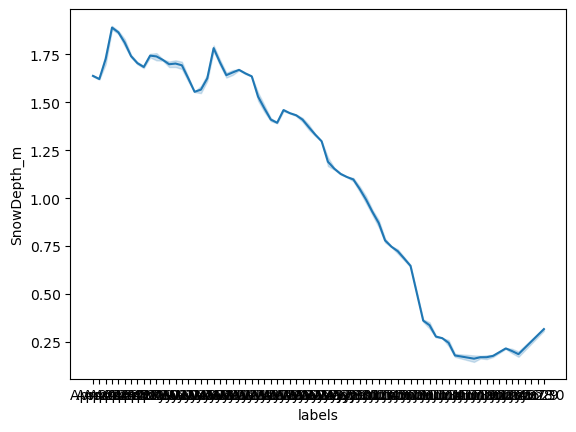

In [77]:
lineplot = sns.lineplot(data = max_period, x = 'labels', y = 'SnowDepth_m')

In [78]:
feb_start = '2022-02-01'
may_end = '2022-05-31'

febmay_mask = (hourly_df['Timestamp'] >= feb_start) & (hourly_df['Timestamp'] <= may_end)
febmay = hourly_df.loc[febmay_mask]
febmay.head()

,Timestamp,AirTemp_DegC,Avg_AirTemp_DegC,RH%,SnowDepth_m,Q,WindSpeed_Max_m/s,WindSpeed_m/s,WindDir_D1_Deg,WindDir_SD1_Deg,...,CNR4TK_K,RsNet_W/m^2,RlNet_W/m^2,Albedo%,Rn_W/m^2,LUpCo_W/m^2,LDnCo_W/m^2,Shortwave_Albedo_W/m^2,Longwave_Albedo_W/m^2,labels
16134,2022-02-01 10:00:00,-13.70,-13.65,82.60,1.201,200,3.469,1.447,79.73,39.71,...,261.2,-32.24,5.637,1.799,-26.61,263.7,258,NaN,NaN,Feb 01
16135,2022-02-01 11:00:00,-12.50,-13.38,74.99,1.203,190,6.938,1.672,93.30,53.13,...,263.7,192.8,7.891,0.651,200.6,272.8,264.9,0.651095,NaN,Feb 01
16136,2022-02-01 12:00:00,-12.72,-12.55,73.63,1.201,189,5.253,1.176,88.70,60.66,...,264.0,110.4,13.3,0.68,123.7,273.6,260.3,0.679629,NaN,Feb 01
16137,2022-02-01 13:00:00,-11.52,-11.48,65.43,1.196,189,3.548,0.568,186.10,67.45,...,267.0,102.8,20.06,0.639,122.8,286.3,266.3,0.639143,NaN,Feb 01
16138,2022-02-01 14:00:00,-11.47,-11.90,64.91,1.196,189,4.802,0.876,101.80,48.57,...,264.8,44.62,13.75,0.736,58.37,276,262.2,0.735782,NaN,Feb 01


In [85]:
# Create a column to hold rounded wind direction data for further plotting
round_degHolder = []
for deg in hourly_df['WindDir_D1_Deg']:
    deg = round(deg)
    deg = int(deg)
    round_degHolder.append(deg)
hourly_df['WindDir_RoundedDeg'] = round_degHolder
hourly_df['WindDir_RoundedDeg']

6226     229
6227     223
6228     227
6229     251
6230     253
        ... 
19712    276
19713    266
19714    261
19715    278
19716    318
Name: WindDir_RoundedDeg, Length: 7266, dtype: int64

In [87]:
# Create a wind dataframe for the hourly data for the entire period
wind_data = hourly_df[['Timestamp', 'WindDir_RoundedDeg','WindSpeed_m/s','labels']]
wind_data['month'] = pd.to_datetime(wind_data['Timestamp']).dt.strftime('%m')
wind_data.head()

/var/folders/1h/qds9mkm123b7fhmghg50vg6w62xq56/T/ipykernel_49414/2171474820.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wind_data['month'] = pd.to_datetime(wind_data['Timestamp']).dt.strftime('%m')


,Timestamp,WindDir_RoundedDeg,WindSpeed_m/s,labels,month
6226,2021-10-01 00:00:00,229,0.406,Oct 01,10
6227,2021-10-01 01:00:00,223,0.304,Oct 01,10
6228,2021-10-01 02:00:00,227,0.218,Oct 01,10
6229,2021-10-01 03:00:00,251,0.365,Oct 01,10
6230,2021-10-01 04:00:00,253,0.137,Oct 01,10


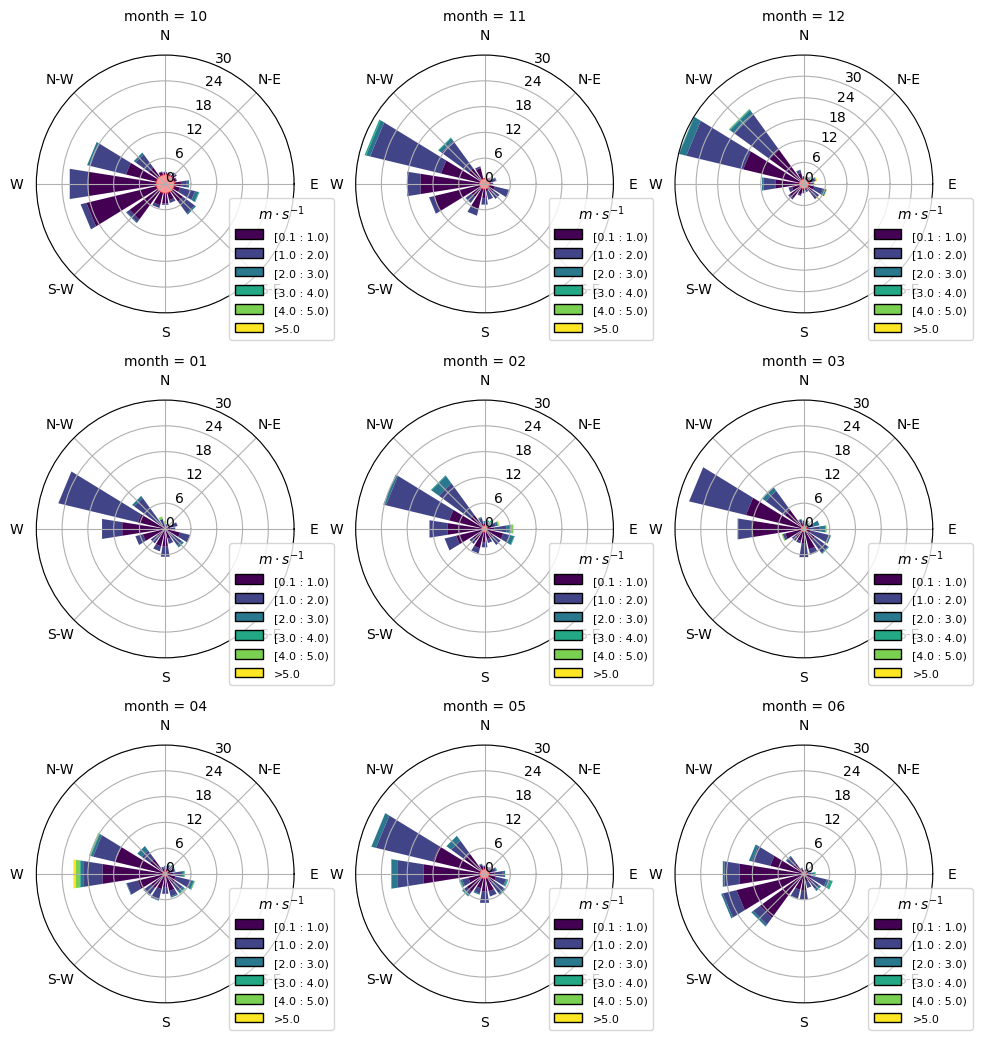

In [88]:
# View subplots of wind data for the Hourglass site during the period of record.
# Separate each wind diagram by the Month
def plot_windrose_subplots(data, *, direction, var, color=None, **kwargs):
    """wrapper function to create subplots per axis"""
    ax = plt.gca()
    ax = WindroseAxes.from_ax(ax=ax)
    plot_windrose(direction_or_df=data[direction], var=data[var], ax=ax, **kwargs)


# this creates the raw subplot structure with a subplot per value in month.
g = sns.FacetGrid(
    data=wind_data,
    # the column name for each level a subplot should be created
    col="month",
    # place a maximum of 3 plots per row
    col_wrap=3,
    subplot_kws={"projection": "windrose"},
    sharex=False,
    sharey=False,
    despine=False,
    height=3.5,
)

g.map_dataframe(
    plot_windrose_subplots,
    direction='WindDir_RoundedDeg',
    var='WindSpeed_m/s',
    normed=True,
    # manually set bins, so they match for each subplot
    bins=(0.1, 1, 2, 3, 4, 5),
    calm_limit=0.05,
    kind="bar",
)

# make the subplots easier to compare, by having the same y-axis range
y_ticks = range(0, 31, 6)
for ax in g.axes:
    ax.set_legend(
        title="$m \cdot s^{-1}$", bbox_to_anchor=(1.15, -0.1), loc="lower right"
    )
    ax.set_rgrids(y_ticks, y_ticks)

# adjust the spacing between the subplots to have sufficient space between plots
plt.subplots_adjust(wspace=-0.1)

In [90]:
# Create a focus for the days surrounding March 25
focus_start = '2022-03-19'
focus_end = '2022-03-27'
# Create a mask for dates between the start and end date
focus_mask = (hourly_df['Timestamp'] >= focus_start) & (hourly_df['Timestamp'] <= focus_end)
# Create a new data frame to view how the variables change over this time period
Mar25_focus = hourly_df.loc[focus_mask]
Mar25_focus.tail()

,Timestamp,AirTemp_DegC,Avg_AirTemp_DegC,RH%,SnowDepth_m,Q,WindSpeed_Max_m/s,WindSpeed_m/s,WindDir_D1_Deg,WindDir_SD1_Deg,...,RsNet_W/m^2,RlNet_W/m^2,Albedo%,Rn_W/m^2,LUpCo_W/m^2,LDnCo_W/m^2,Shortwave_Albedo_W/m^2,Longwave_Albedo_W/m^2,labels,WindDir_RoundedDeg
17408,2022-03-26 19:00:00,NaN,NaN,47.54,NaN,192,2.332,0.815,304.6,45.65,...,NAN,NAN,NAN,NAN,NAN,NAN,NaN,NaN,Mar 26,305
17409,2022-03-26 20:00:00,2.340,NaN,65.22,1.446,194,3.195,0.382,294.2,27.59,...,NAN,NAN,NAN,NAN,NAN,NAN,NaN,NaN,Mar 26,294
17410,2022-03-26 21:00:00,2.248,2.310,64.53,1.448,193,1.490,0.299,284.6,28.62,...,NAN,NAN,NAN,NAN,NAN,NAN,NaN,NaN,Mar 26,285
17411,2022-03-26 22:00:00,2.562,2.187,64.44,1.448,194,1.686,0.351,275.1,25.95,...,NAN,NAN,NAN,NAN,NAN,NAN,NaN,NaN,Mar 26,275
17412,2022-03-26 23:00:00,2.288,2.830,70.12,1.439,181,2.274,0.584,278.0,38.95,...,NAN,NAN,NAN,NAN,NAN,NAN,NaN,NaN,Mar 26,278


In [107]:
# Create a wind dataframe for the focus data for the dates leading up to and following March 25
Mar25_focus_data = Mar25_focus[['Timestamp', 'WindDir_RoundedDeg','WindSpeed_Max_m/s','labels','SnowDepth_m','Avg_AirTemp_DegC']]
Mar25_focus_data.head()

,Timestamp,WindDir_RoundedDeg,WindSpeed_Max_m/s,labels,SnowDepth_m,Avg_AirTemp_DegC
17222,2022-03-19 00:00:00,290,2.881,Mar 19,1.538,-4.000
17223,2022-03-19 01:00:00,282,2.607,Mar 19,1.539,-4.119
17224,2022-03-19 02:00:00,283,2.783,Mar 19,1.535,-3.647
17225,2022-03-19 03:00:00,291,3.469,Mar 19,1.542,-4.074
17226,2022-03-19 04:00:00,293,2.960,Mar 19,1.538,-3.793


In [94]:
# Create a start and end date to focus on the month of March specifically
start_date = '2022-03-01'
end_date = '2022-04-01'
# Now create a mask and filter the hourly data by this same period
mask_hourly = (hourly_df['Timestamp'] >= start_date) & (hourly_df['Timestamp'] <= end_date)
Mar_focus_hourly = hourly_df.loc[mask_hourly]
Mar_focus_hourly.head()

,Timestamp,AirTemp_DegC,Avg_AirTemp_DegC,RH%,SnowDepth_m,Q,WindSpeed_Max_m/s,WindSpeed_m/s,WindDir_D1_Deg,WindDir_SD1_Deg,...,RsNet_W/m^2,RlNet_W/m^2,Albedo%,Rn_W/m^2,LUpCo_W/m^2,LDnCo_W/m^2,Shortwave_Albedo_W/m^2,Longwave_Albedo_W/m^2,labels,WindDir_RoundedDeg
16790,2022-03-01 00:00:00,NaN,NaN,71.29,NaN,189,3.881,1.334,313.8,59.96,...,NAN,NAN,NAN,NAN,NAN,NAN,NaN,NaN,Mar 01,314
16791,2022-03-01 01:00:00,1.419,NaN,77.95,1.381,189,3.352,0.974,294.4,38.15,...,NAN,NAN,NAN,NAN,NAN,NAN,NaN,NaN,Mar 01,294
16792,2022-03-01 02:00:00,1.702,1.622,77.32,1.379,170,3.077,1.098,302.6,48.45,...,NAN,NAN,NAN,NAN,NAN,NAN,NaN,NaN,Mar 01,303
16793,2022-03-01 03:00:00,1.035,1.187,82.30,1.378,181,4.155,1.035,293.6,28.96,...,NAN,NAN,NAN,NAN,NAN,NAN,NaN,NaN,Mar 01,294
16794,2022-03-01 04:00:00,1.257,NaN,81.10,1.379,178,3.195,1.200,300.4,40.32,...,NAN,NAN,NAN,NAN,NAN,NAN,NaN,NaN,Mar 01,300


[Text(0.5, 1.0, 'Snow Depth and Air Temperature Change During March')]

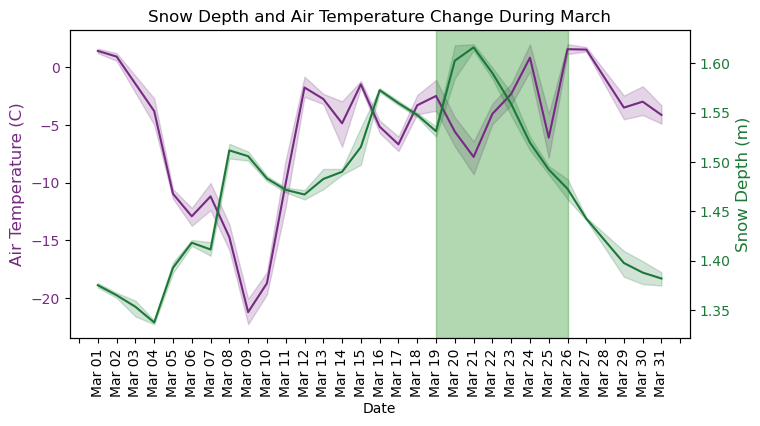

In [145]:
# Try to plot wind speed and snow depth on the same plot

color_temp = "#762a83"
color_depth = "#1b7837"

fig, ax1 = plt.subplots(figsize=(8, 4))

speed = sns.lineplot(data = Mar_focus_hourly, x = 'labels', y = 'Avg_AirTemp_DegC', ax = ax1, color = color_temp)
speed.xaxis.set_major_locator(mdates.DayLocator(interval=1))

ax1.set_xlabel("Date")
ax1.set_ylabel("Air Temperature (C)", color=color_temp, fontsize=12)
ax1.tick_params(axis="y", labelcolor=color_temp)
plt.xticks(rotation = 90)

ax1.axvspan('Mar 19', 'Mar 26', 
           label="Mar 25 Focus",color="green", alpha=0.3)

ax2 = ax1.twinx()
sns.lineplot(data = Mar_focus_hourly, x = 'labels', y = 'SnowDepth_m', ax = ax2, color = color_depth)

ax2.set_ylabel("Snow Depth (m)", color=color_depth, fontsize=12)
ax2.tick_params(axis="y", labelcolor=color_depth)

ax1.set(title = 'Snow Depth and Air Temperature Change During March')

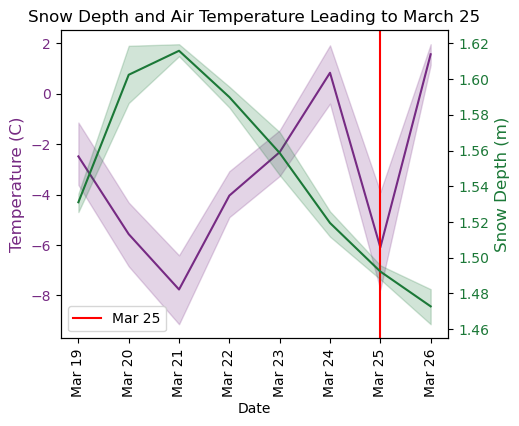

In [147]:
fig, ax1 = plt.subplots(figsize=(5, 4))

speed = sns.lineplot(data = Mar25_focus_data, x = 'labels', y = 'Avg_AirTemp_DegC', ax = ax1, color = color_temp)

ax1.set_xlabel("Date")
ax1.set_ylabel("Temperature (C)", color=color_temp, fontsize=12)
ax1.tick_params(axis="y", labelcolor=color_temp)
plt.xticks(rotation = 90)

ax1.axvline(x = 'Mar 25', label = 'Mar 25', color = 'r')


ax2 = ax1.twinx()
sns.lineplot(data = Mar25_focus_data, x = 'labels', y = 'SnowDepth_m', ax = ax2, color = color_depth)

ax2.set_ylabel("Snow Depth (m)", color=color_depth, fontsize=12)
ax2.tick_params(axis="y", labelcolor=color_depth)

ax1.set(title = 'Snow Depth and Air Temperature Leading to March 25')
ax1.legend(loc = 'lower left')

plt.savefig('/Users/f67f911/Desktop/Hourglass_WX/Figures/Mar25_Focus_DepthTemp.png', bbox_inches = "tight")

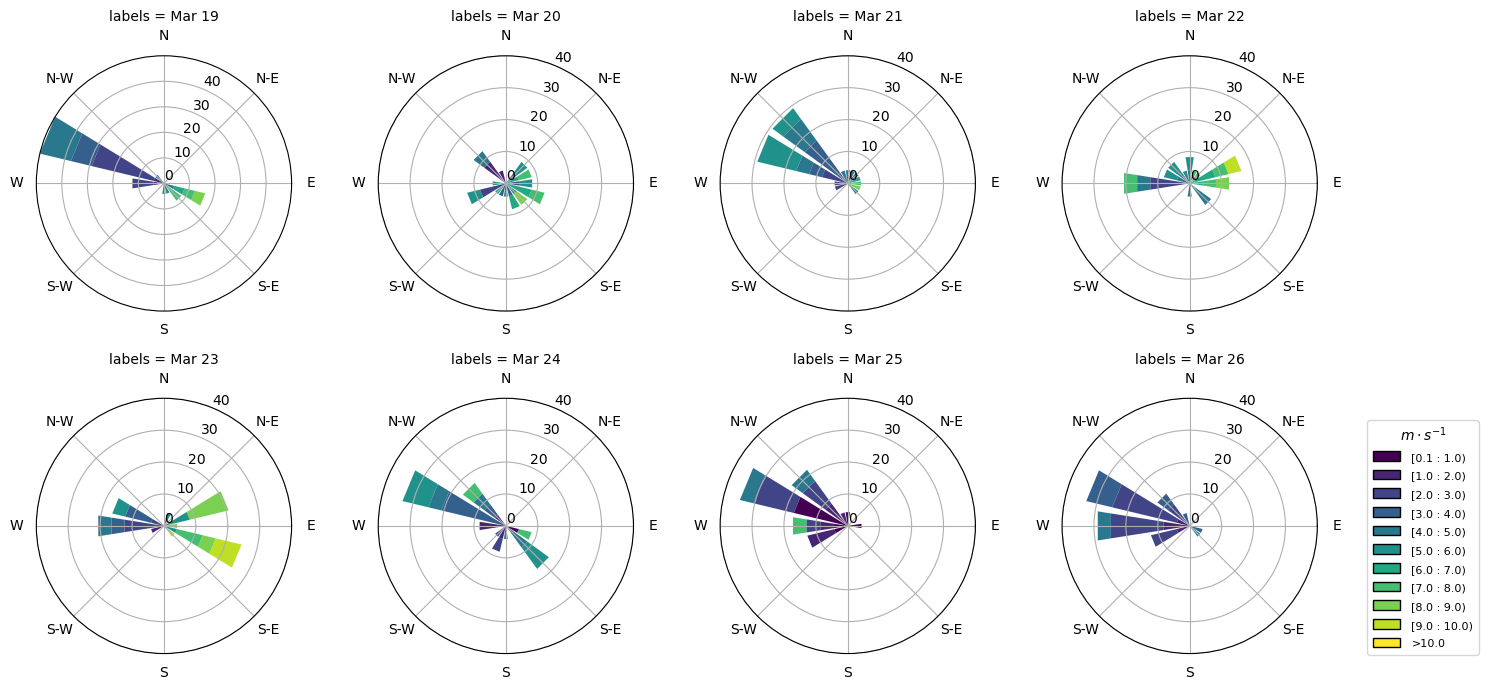

In [116]:
# View subplots of wind data for the Hourglass site during the period of record.
def plot_windrose_subplots(data, *, direction, var, color=None, **kwargs):
    """wrapper function to create subplots per axis"""
    ax = plt.gca()
    ax = WindroseAxes.from_ax(ax=ax)
    plot_windrose(direction_or_df=data[direction], var=data[var], ax=ax, **kwargs)


# this creates the raw subplot structure with a subplot per value in month.
g = sns.FacetGrid(
    data=Mar25_focus_data,
    # the column name for each level a subplot should be created
    col="labels",
    # place a maximum of 3 plots per row
    col_wrap=4,
    subplot_kws={"projection": "windrose"},
    sharex=False,
    sharey=False,
    despine=False,
    height=3.5,
)

g.map_dataframe(
    plot_windrose_subplots,
    direction='WindDir_RoundedDeg',
    var='WindSpeed_Max_m/s',
    normed=True,
    # manually set bins, so they match for each subplot
    bins=(0.1, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10),
    calm_limit=0.1,
    kind="bar",
)

# make the subplots easier to compare, by having the same y-axis range
y_ticks = range(0, 41, 10)
for ax in g.axes:
#     ax.set_legend(
#         title="$m \cdot s^{-1}$", bbox_to_anchor=(1.55, 0), loc="lower right"
#     )
    ax.set_rgrids(y_ticks, y_ticks)

# adjust the spacing between the subplots to have sufficient space between plots
plt.subplots_adjust(wspace=.1)
ax.set_legend(title="$m \cdot s^{-1}$", bbox_to_anchor=(1.2, 0))
plt.savefig('/Users/f67f911/Desktop/Hourglass_WX/Figures/Mar25_windfocus.png', bbox_inches = "tight")

In [117]:
# Create a start and end date for February
Feb_start = '2022-02-01'
Apr_end = '2022-04-30'

# Create a focus for February
mask_FebApr = (hourly_df['Timestamp'] >= Feb_start) & (hourly_df['Timestamp'] <= Apr_end)
FebApr = hourly_df.loc[mask_FebApr]
FebApr.head()

,Timestamp,AirTemp_DegC,Avg_AirTemp_DegC,RH%,SnowDepth_m,Q,WindSpeed_Max_m/s,WindSpeed_m/s,WindDir_D1_Deg,WindDir_SD1_Deg,...,RsNet_W/m^2,RlNet_W/m^2,Albedo%,Rn_W/m^2,LUpCo_W/m^2,LDnCo_W/m^2,Shortwave_Albedo_W/m^2,Longwave_Albedo_W/m^2,labels,WindDir_RoundedDeg
16134,2022-02-01 10:00:00,-13.70,-13.65,82.60,1.201,200,3.469,1.447,79.73,39.71,...,-32.24,5.637,1.799,-26.61,263.7,258,NaN,NaN,Feb 01,80
16135,2022-02-01 11:00:00,-12.50,-13.38,74.99,1.203,190,6.938,1.672,93.30,53.13,...,192.8,7.891,0.651,200.6,272.8,264.9,0.651095,NaN,Feb 01,93
16136,2022-02-01 12:00:00,-12.72,-12.55,73.63,1.201,189,5.253,1.176,88.70,60.66,...,110.4,13.3,0.68,123.7,273.6,260.3,0.679629,NaN,Feb 01,89
16137,2022-02-01 13:00:00,-11.52,-11.48,65.43,1.196,189,3.548,0.568,186.10,67.45,...,102.8,20.06,0.639,122.8,286.3,266.3,0.639143,NaN,Feb 01,186
16138,2022-02-01 14:00:00,-11.47,-11.90,64.91,1.196,189,4.802,0.876,101.80,48.57,...,44.62,13.75,0.736,58.37,276,262.2,0.735782,NaN,Feb 01,102


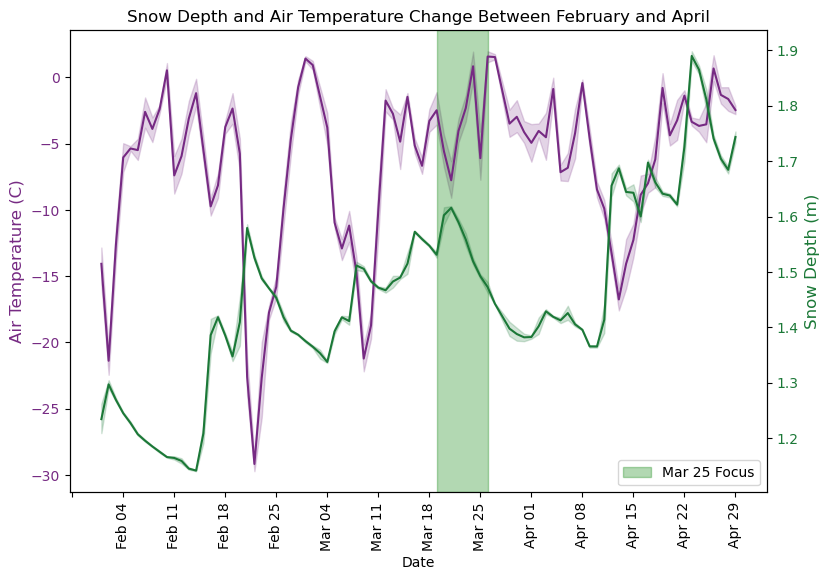

In [149]:
# Try to plot wind speed and snow depth on the same plot

color_temp = "#762a83"
color_depth = "#1b7837"

fig, ax1 = plt.subplots(figsize=(9, 6))

speed = sns.lineplot(data = FebApr, x = 'labels', y = 'Avg_AirTemp_DegC', ax = ax1, color = color_temp)
speed.xaxis.set_major_locator(mdates.DayLocator(interval=7))

ax1.set_xlabel("Date")
ax1.set_ylabel("Air Temperature (C)", color=color_temp, fontsize=12)
ax1.tick_params(axis="y", labelcolor=color_temp)
plt.xticks(rotation = 90)

ax1.axvspan('Mar 19', 'Mar 26', 
           label="Mar 25 Focus",color="green", alpha=0.3)

ax2 = ax1.twinx()
sns.lineplot(data = FebApr, x = 'labels', y = 'SnowDepth_m', ax = ax2, color = color_depth)

ax2.set_ylabel("Snow Depth (m)", color=color_depth, fontsize=12)
ax2.tick_params(axis="y", labelcolor=color_depth)

ax1.set(title = 'Snow Depth and Air Temperature Change Between February and April')
ax1.legend(loc = 'lower right')

plt.savefig('/Users/f67f911/Desktop/Hourglass_WX/Figures/FebApr_DepthTemp.png', bbox_inches = "tight")

In [159]:
FebApr['week'] = pd.to_datetime(FebApr['Timestamp']).dt.strftime('%U')
FebApr.head()

/var/folders/1h/qds9mkm123b7fhmghg50vg6w62xq56/T/ipykernel_49414/2955805760.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  FebApr['week'] = pd.to_datetime(FebApr['Timestamp']).dt.strftime('%U')


,Timestamp,AirTemp_DegC,Avg_AirTemp_DegC,RH%,SnowDepth_m,Q,WindSpeed_Max_m/s,WindSpeed_m/s,WindDir_D1_Deg,WindDir_SD1_Deg,...,RlNet_W/m^2,Albedo%,Rn_W/m^2,LUpCo_W/m^2,LDnCo_W/m^2,Shortwave_Albedo_W/m^2,Longwave_Albedo_W/m^2,labels,WindDir_RoundedDeg,week
16134,2022-02-01 10:00:00,-13.70,-13.65,82.60,1.201,200,3.469,1.447,79.73,39.71,...,5.637,1.799,-26.61,263.7,258,NaN,NaN,Feb 01,80,05
16135,2022-02-01 11:00:00,-12.50,-13.38,74.99,1.203,190,6.938,1.672,93.30,53.13,...,7.891,0.651,200.6,272.8,264.9,0.651095,NaN,Feb 01,93,05
16136,2022-02-01 12:00:00,-12.72,-12.55,73.63,1.201,189,5.253,1.176,88.70,60.66,...,13.3,0.68,123.7,273.6,260.3,0.679629,NaN,Feb 01,89,05
16137,2022-02-01 13:00:00,-11.52,-11.48,65.43,1.196,189,3.548,0.568,186.10,67.45,...,20.06,0.639,122.8,286.3,266.3,0.639143,NaN,Feb 01,186,05
16138,2022-02-01 14:00:00,-11.47,-11.90,64.91,1.196,189,4.802,0.876,101.80,48.57,...,13.75,0.736,58.37,276,262.2,0.735782,NaN,Feb 01,102,05


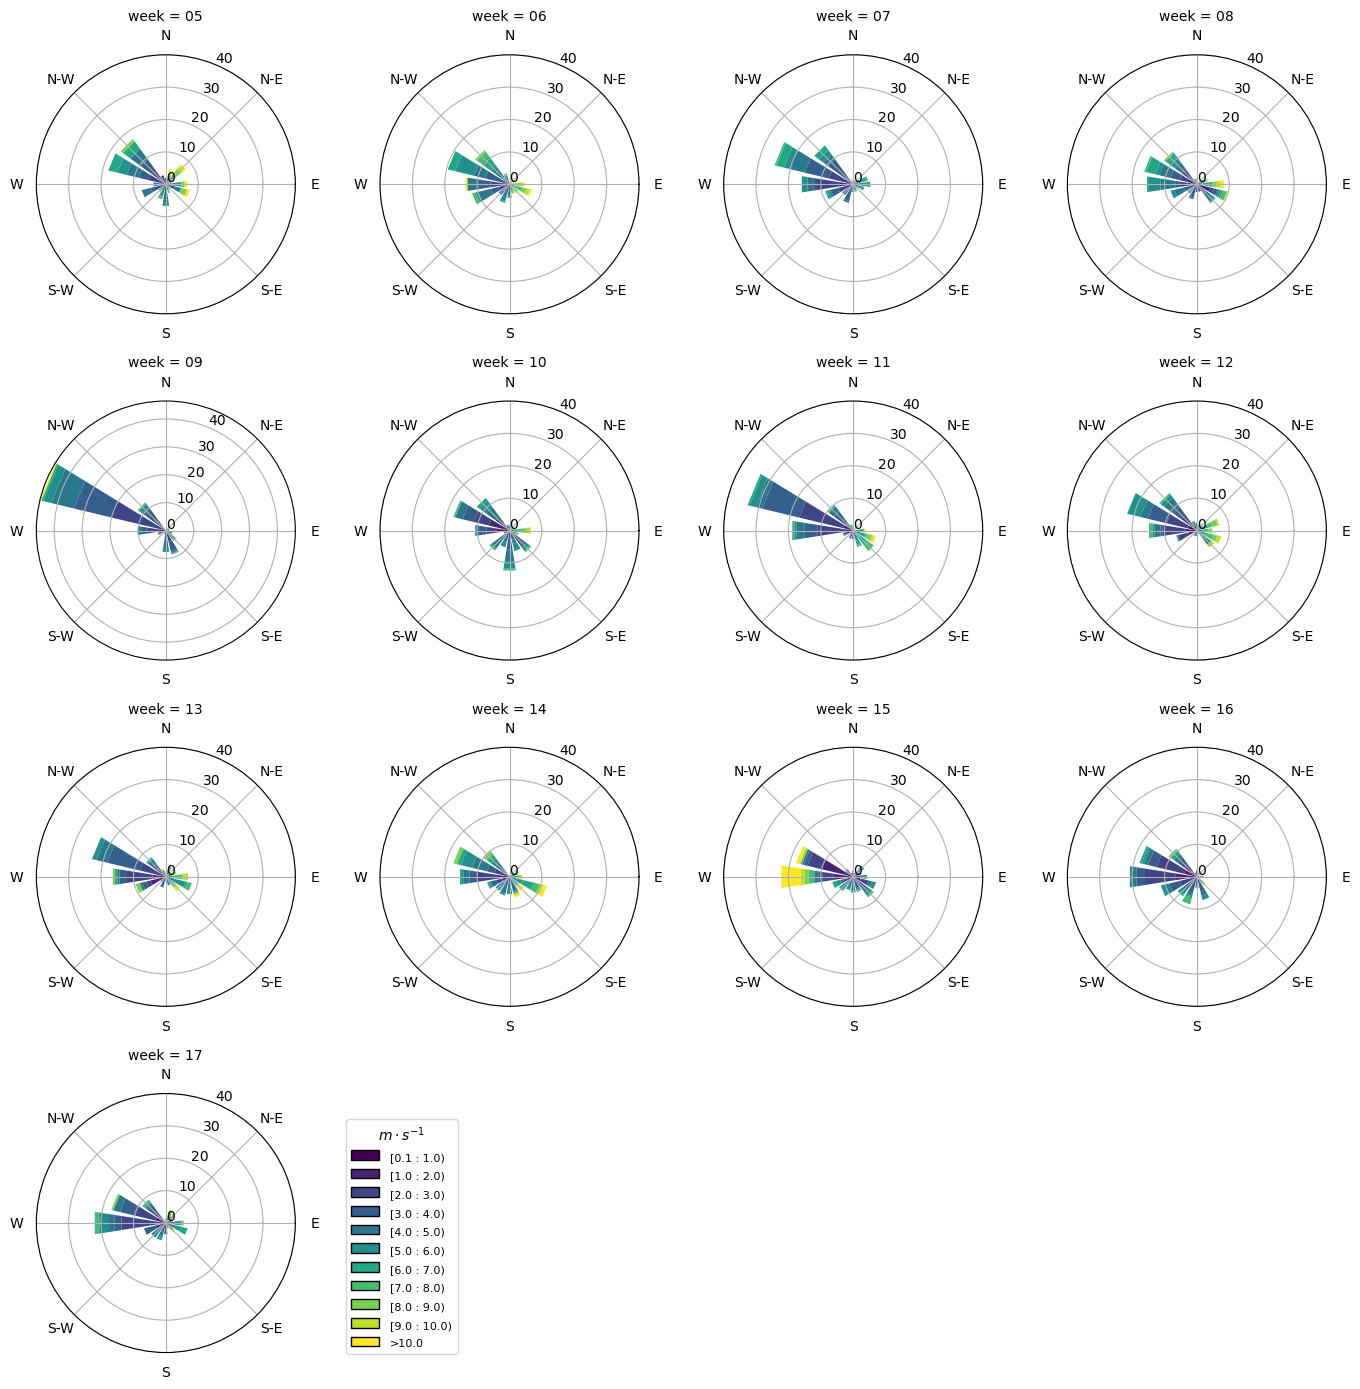

In [161]:
# View subplots of wind data for the Hourglass site during the period of record.
def plot_windrose_subplots(data, *, direction, var, color=None, **kwargs):
    """wrapper function to create subplots per axis"""
    ax = plt.gca()
    ax = WindroseAxes.from_ax(ax=ax)
    plot_windrose(direction_or_df=data[direction], var=data[var], ax=ax, **kwargs)


# this creates the raw subplot structure with a subplot per value in month.
g = sns.FacetGrid(
    data=FebApr,
    # the column name for each level a subplot should be created
    col="week",
    # place a maximum of 3 plots per row
    col_wrap=4,
    subplot_kws={"projection": "windrose"},
    sharex=False,
    sharey=False,
    despine=False,
    height=3.5,
)

g.map_dataframe(
    plot_windrose_subplots,
    direction='WindDir_RoundedDeg',
    var='WindSpeed_Max_m/s',
    normed=True,
    # manually set bins, so they match for each subplot
    bins=(0.1, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10),
    calm_limit=0.1,
    kind="bar",
)

# make the subplots easier to compare, by having the same y-axis range
y_ticks = range(0, 41, 10)
for ax in g.axes:
#     ax.set_legend(
#         title="$m \cdot s^{-1}$", bbox_to_anchor=(1.55, 0), loc="lower right"
#     )
    ax.set_rgrids(y_ticks, y_ticks)

# adjust the spacing between the subplots to have sufficient space between plots
plt.subplots_adjust(wspace=.1)
ax.set_legend(title="$m \cdot s^{-1}$", bbox_to_anchor=(1.2, 0))
# plt.savefig('/Users/f67f911/Desktop/Hourglass_WX/Figures/Mar25_windfocus.png', bbox_inches = "tight")